<a href="https://colab.research.google.com/github/teamgaon/KLUE/blob/main/KLUE_Teamgaon_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리, 패키지

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the followin line:
!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install transformers

     |████████████████████████████████| 311 kB 5.3 MB/s 
     |████████████████████████████████| 3.8 MB 75.3 MB/s 
     |████████████████████████████████| 212 kB 86.0 MB/s 
     |████████████████████████████████| 134 kB 80.4 MB/s 
     |████████████████████████████████| 1.1 MB 70.7 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 144 kB 77.9 MB/s 
     |████████████████████████████████| 271 kB 83.1 MB/s 
     |████████████████████████████████| 895 kB 76.8 MB/s 
     |████████████████████████████████| 6.5 MB 73.7 MB/s 
     |████████████████████████████████| 596 kB 79.2 MB/s 
     |████████████████████████████████| 1.2 MB 70.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 58 kB 2.8 MB/s 
     |████████████████████████████████| 149.9 

- TPU 사용을 위한 accelerate

In [3]:
from accelerate import Accelerator

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from transformers import TrainingArguments, Trainer
from transformers import AutoModel,AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
import gc
from transformers import AdamW
from transformers import get_scheduler, get_cosine_with_hard_restarts_schedule_with_warmup
from tqdm.auto import tqdm
from datasets import load_metric
import warnings
warnings.filterwarnings('ignore')
from accelerate import notebook_launcher

# 데이터

* KAKAO
  + https://github.com/teamgaon/KorNLUDatasets

* KLUE
  + https://klue-benchmark.com/tasks/68/data/description


In [5]:
PATH =  '/content/drive/MyDrive/KLUE'

# 데이콘 데이터셋
train = pd.read_csv(os.path.join(PATH, 'train_data.csv'), encoding='utf-8')
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')

# 카카오 데이터셋
kakao_snli = pd.read_csv('/content/drive/MyDrive/KLUE/snli_1.0_train.ko.tsv', sep='\t', encoding='utf-8')
kakao_snli = kakao_snli[:100000]
kakao_dev = pd.read_csv('/content/drive/MyDrive/KLUE/xnli.dev.ko.tsv', sep='\t', encoding='utf-8')
kakao_test = pd.read_csv('/content/drive/MyDrive/KLUE/xnli.test.ko.tsv', sep='\t', encoding='utf-8')
kakao_dev = pd.concat([kakao_dev,kakao_test, kakao_snli])
kakao_dev.rename(columns = {'sentence1':'premise','sentence2':'hypothesis','gold_label':'label'},inplace=True)

# KLUE 데이터셋
klue_dev = pd.read_json('/content/drive/MyDrive/KLUE/klue-nli-v1.1_dev.json')
klue_dev = klue_dev[['premise', 'hypothesis', 'gold_label']]
klue_dev.rename(columns = {'gold_label':'label'}, inplace=True)

# 데이콘, 카카오, KLUE 데이터셋 병합
train = pd.concat([train, klue_dev, kakao_dev], axis=0)
train = train.reset_index(drop=True)
train['index'] = train.index
train = train.dropna()
train = train.reset_index(drop=True)
train['index'] = train.index
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
134514,134514,같은 방향으로 보이는 숲이 우거진 지역에 의상을 입은 사람들이 모여 있다.,사람들은 의상을 입는다,entailment
134515,134515,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,하이힐을 신은 남자,contradiction
134516,134516,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,서 있는 소녀,entailment
134517,134517,검은 원피스에 커다란 흰 활을 든 소녀가 카메라를 등지고 서 있다.,사진 촬영 준비를 하고 있는 소녀,neutral


- 데이터는 동일한 premise에 세 가지의 hypothesis로 구성  
 각각의 hypothesis는 대체로 contradiction, entailment, neutral이 하나씩 매칭

In [ ]:
train.sort_values(by='premise')[:15]

,index,premise,hypothesis,label
98035,98035,'공원 자원봉사자' 티셔츠를 입은 소녀들이 건물 밖에 서 있다.,한 무리의 소녀들이 비명을 지르며 뛰어다닌다.,contradiction
98037,98037,'공원 자원봉사자' 티셔츠를 입은 소녀들이 건물 밖에 서 있다.,사람들은 건물 밖에서 파크스 티셔츠를 입고 있다.,neutral
98036,98036,'공원 자원봉사자' 티셔츠를 입은 소녀들이 건물 밖에 서 있다.,몇몇 소녀들이 건물 밖에 서 있다.,entailment
43342,43342,'롱 라이브 더 데드' 티셔츠를 입은 남자가 노란 택시 옆에 쇼핑 카트를 밀고 있다.,남자가 수레를 노란 택시에 밀어넣을 것이다.,neutral
43344,43344,'롱 라이브 더 데드' 티셔츠를 입은 남자가 노란 택시 옆에 쇼핑 카트를 밀고 있다.,셔츠를 입지 않은 남자가 트렁크에 쇼핑 카트를 싣고 택시를 밀고 있다.,contradiction
43343,43343,'롱 라이브 더 데드' 티셔츠를 입은 남자가 노란 택시 옆에 쇼핑 카트를 밀고 있다.,티셔츠를 입은 남자가 택시 옆에 쇼핑 카트를 밀고 있다.,entailment
57311,57311,'샤인 델리'라는 건물 앞에 사람들이 있다.,사람들이 건물 앞에 있다.,entailment
57310,57310,'샤인 델리'라는 건물 앞에 사람들이 있다.,사람들은 월마트에 있다.,contradiction
57312,57312,'샤인 델리'라는 건물 앞에 사람들이 있다.,그 건물은 식당이다.,neutral
118208,118208,'헤럴드'는 미니마트에서 팔리고 광고되고 있다.,지역 쇼핑몰의 '데일리 뉴스',contradiction


- train셋의 label은 contradiction, entailment, neutral이 고르게 분포

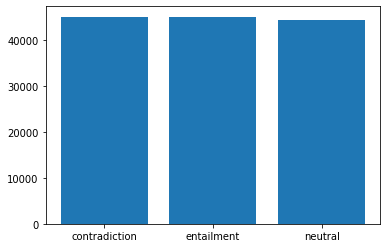

In [ ]:
num_contradiction = len(train[train['label'] == 'contradiction'])
num_entailment = len(train[train['label'] == 'entailment'])
num_neutral = len(train[train['label'] == 'neutral'])

labels = ['contradiction', 'entailment', 'neutral']
counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

# 토크나이저, 함수

In [6]:
from transformers import AutoTokenizer

checkpoint = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/734k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [7]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['labels'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [8]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label

In [9]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 학습

* Model
  + Roberta-large

* Optimizer
  + AdamW

* Learning rate scheduler
  + Cosine annealing with warmup

In [ ]:
def training_function():
  accelerator = Accelerator()

  train_dataloader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=16, sampler=train_subsampler)
  eval_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=16, sampler=test_subsampler)

  config = AutoConfig.from_pretrained(checkpoint)
  config.num_labels = 3
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)

  optimizer = AdamW(model.parameters(), lr=	1e-5)

  model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(model, optimizer, train_dataloader, eval_dataloader)

  num_epochs = 10
  num_training_steps = num_epochs * len(train_dataloader)
  progress_bar = tqdm(range(num_training_steps))
  lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
      optimizer=optimizer,
      num_warmup_steps=1,
      num_training_steps=num_training_steps,
  )

  for epoch in range(num_epochs):
      train_acc = 0.0
      test_acc = 0.0

      model.train()
      for batch_id, batch in enumerate(train_dataloader):
          outputs = model(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'])
          loss = F.cross_entropy(outputs[0], batch['labels'])
          accelerator.backward(loss)

          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()
          progress_bar.update(1)
          train_acc += calc_accuracy(outputs.logits, batch['labels'])
      print("epoch {} train acc {}".format(epoch+1, train_acc / (batch_id+1)))

      model.eval()
      for batch_id, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch['input_ids'], batch['attention_mask'], batch['token_type_ids'])

        test_acc += calc_accuracy(outputs.logits, batch['labels'])
      print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))
      gc.collect()
  accelerator.wait_for_everyone()
  unwrapped_model = accelerator.unwrap_model(model)
  unwrapped_model.save_pretrained('/content/drive/MyDrive/220228/model' + str(fold), save_function=accelerator.save)

* 5 fold ensemble
  + Cross validation이 아닌 각 fold 별 모델로 판단한 결과를 Voting ensemble 하기 위함

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

print('--------------------------------')

tokenized_train = tokenizer(
  list(train['premise']),
  list(train['hypothesis']),
  return_tensors="pt",
  max_length=128, # Max_Length = 190
  padding=True,
  truncation=True,
  add_special_tokens=True
  )
  
for fold, (train_ids, test_ids) in enumerate(kfold.split(train, train['label'])):
  print(f'FOLD {fold}')

  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  train_label = label_to_num(train['label'].values)

  train_dataset = BERTDataset(tokenized_train, train_label)

  notebook_launcher(training_function)

--------------------------------
FOLD 0
Launching a training on 8 TPU cores.


Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

epoch 1 train acc 0.7933263971462544
epoch 1 train acc 0.7954072532699168
epoch 1 train acc 0.7899821640903686
epoch 1 train acc 0.7914684898929846
epoch 1 train acc 0.7891646848989299
epoch 1 train acc 0.7958531510107015
epoch 1 train acc 0.7958531510107015
epoch 1 train acc 0.7928061831153389
epoch 1 test acc 0.8548578199052133
epoch 1 test acc 0.8483412322274881
epoch 1 test acc 0.8385663507109005
epoch 1 test acc 0.8545616113744076
epoch 1 test acc 0.8536729857819905
epoch 1 test acc 0.8613744075829384
epoch 1 test acc 0.8578199052132701
epoch 1 test acc 0.8566350710900474
epoch 2 train acc 0.8729934601664685
epoch 2 train acc 0.8776753864447087
epoch 2 train acc 0.875
epoch 2 train acc 0.8770808561236623
epoch 2 train acc 0.8752229488703924
epoch 2 train acc 0.8784185493460166
epoch 2 train acc 0.8726218787158145
epoch 2 train acc 0.8751486325802615
epoch 2 test acc 0.8563388625592417
epoch 2 test acc 0.860781990521327
epoch 2 test acc 0.8667061611374408
epoch 2 test acc 0.8598933

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

epoch 1 train acc 0.7922116527942925
epoch 1 train acc 0.7908739595719382
epoch 1 train acc 0.795332936979786
epoch 1 train acc 0.7933263971462544
epoch 1 train acc 0.7926575505350772
epoch 1 train acc 0.7939952437574316
epoch 1 train acc 0.7966706302021404
epoch 1 train acc 0.7928061831153389
epoch 1 test acc 0.8495260663507109
epoch 1 test acc 0.8338270142180095
epoch 1 test acc 0.8320497630331753
epoch 1 test acc 0.8584123222748815
epoch 1 test acc 0.8501184834123223
epoch 1 test acc 0.8504146919431279
epoch 1 test acc 0.8507109004739336
epoch 1 test acc 0.840047393364929
epoch 2 train acc 0.8773038049940547
epoch 2 train acc 0.8744054696789536
epoch 2 train acc 0.8779726516052319
epoch 2 train acc 0.8774524375743162
epoch 2 train acc 0.8764120095124851
epoch 2 train acc 0.8748513674197385
epoch 2 train acc 0.8734393579072532
epoch 2 train acc 0.8721016646848989
epoch 2 test acc 0.8619668246445498
epoch 2 test acc 0.8628554502369669
epoch 2 test acc 0.8527843601895735
epoch 2 test a

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

epoch 1 train acc 0.790205112960761
epoch 1 train acc 0.7901307966706302
epoch 1 train acc 0.7917657550535078
epoch 1 train acc 0.7864892984542212
epoch 1 train acc 0.7873810939357907
epoch 1 train acc 0.7860434007134364
epoch 1 train acc 0.7874554102259215
epoch 1 train acc 0.7848543400713437
epoch 1 test acc 0.85989336492891
epoch 1 test acc 0.8504146919431279
epoch 1 test acc 0.8453791469194313
epoch 1 test acc 0.8581161137440758
epoch 1 test acc 0.8477488151658767
epoch 1 test acc 0.8480450236966824
epoch 1 test acc 0.8486374407582938
epoch 1 test acc 0.8581161137440758
epoch 2 train acc 0.8766349583828775
epoch 2 train acc 0.8780469678953626
epoch 2 train acc 0.871730083234245
epoch 2 train acc 0.8755945303210464
epoch 2 train acc 0.8732907253269917
epoch 2 train acc 0.8729191438763377
epoch 2 train acc 0.8781956004756243
epoch 2 train acc 0.8738109393579072
epoch 2 test acc 0.8687796208530806
epoch 2 test acc 0.8631516587677726
epoch 2 test acc 0.8661137440758294
epoch 2 test acc

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

epoch 1 train acc 0.7876783590963139
epoch 1 train acc 0.790948275862069
epoch 1 train acc 0.7966706302021404
epoch 1 train acc 0.7910969084423306
epoch 1 train acc 0.7903537455410226
epoch 1 train acc 0.7933263971462544
epoch 1 train acc 0.789833531510107
epoch 1 train acc 0.7954072532699168
epoch 1 test acc 0.8530805687203792
epoch 1 test acc 0.8504146919431279
epoch 1 test acc 0.851303317535545
epoch 1 test acc 0.8504146919431279
epoch 1 test acc 0.8515995260663507
epoch 1 test acc 0.8495260663507109
epoch 1 test acc 0.8430094786729858
epoch 1 test acc 0.8495260663507109
epoch 2 train acc 0.8773781212841855
epoch 2 train acc 0.8806480380499405
epoch 2 train acc 0.8736623067776457
epoch 2 train acc 0.8709126040428062
epoch 2 train acc 0.8741825208085613
epoch 2 train acc 0.8766349583828775
epoch 2 train acc 0.8792360285374554
epoch 2 train acc 0.8756688466111772
epoch 2 test acc 0.8575236966824644
epoch 2 test acc 0.8590047393364929
epoch 2 test acc 0.8510071090047393
epoch 2 test ac

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'cl

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

  0%|          | 0/8410 [00:00<?, ?it/s]

epoch 1 train acc 0.7878269916765755
epoch 1 train acc 0.7874554102259215
epoch 1 train acc 0.7875297265160524
epoch 1 train acc 0.7868608799048752
epoch 1 train acc 0.790205112960761
epoch 1 train acc 0.7793549346016647
epoch 1 train acc 0.7820303210463734
epoch 1 train acc 0.7855975029726516
epoch 1 test acc 0.8566350710900474
epoch 1 test acc 0.8382701421800948
epoch 1 test acc 0.8477488151658767
epoch 1 test acc 0.8504146919431279
epoch 1 test acc 0.8486374407582938
epoch 1 test acc 0.8489336492890995
epoch 1 test acc 0.8421208530805687
epoch 1 test acc 0.8495260663507109
epoch 2 train acc 0.8744797859690844
epoch 2 train acc 0.8741082045184304
epoch 2 train acc 0.875371581450654
epoch 2 train acc 0.8703923900118906
epoch 2 train acc 0.8752229488703924
epoch 2 train acc 0.8689803804994055
epoch 2 train acc 0.8700951248513674
epoch 2 train acc 0.8723989298454221
epoch 2 test acc 0.8643364928909952
epoch 2 test acc 0.8631516587677726
epoch 2 test acc 0.8584123222748815
epoch 2 test a

# 추론

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for fold in range(5):

  config = AutoConfig.from_pretrained(checkpoint)
  config.num_labels = 3
  model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/220228/model' + str(fold), num_labels=3)
  model.resize_token_embeddings(tokenizer.vocab_size)
  accelerator = Accelerator()
  model = accelerator.unwrap_model(model)

  output_pred = []
  output_prob = []

  model, dataloader= accelerator.prepare(model, dataloader)

  model.eval()

  for i, data in enumerate(tqdm(dataloader)):
      with torch.no_grad():
          outputs = model(
              input_ids=data['input_ids'],
              attention_mask=data['attention_mask']
          )
      logits = outputs[0]
      prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
      logits = logits.detach().cpu().numpy()
      result = np.argmax(logits, axis=-1)
      output_pred.append(result)
      output_prob.append(prob)
      
  pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()

  def num_to_label(label):
      label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
      str_label = []

      for i, v in enumerate(label):
          str_label.append([i,label_dict[v]])
      
      return str_label

  answer = num_to_label(pred_answer)

  df_label = pd.DataFrame(answer, columns=['index', 'label'])
  df_prob = pd.DataFrame(output_prob)

  df_label.to_csv('/content/drive/MyDrive/220228/pred_label'+str(fold)+'.csv', index=False)
  df_prob.to_csv('/content/drive/MyDrive/220228/pred_prob'+str(fold)+'.csv', index=False)

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

## hardvoting

### voting algorithm 
  + <strong> 5개의 모델이 판단한 5개의 label 중 동일한 label이 3개 이상이면 해당 label로 분류, 그 외의 경우는 neutral로 분류
  
  + 앞선 과정을 거쳐 neutral로 분류된 데이터 중 5개의 label이 neutral과 entailment, <br> neutral과 contradiction이 경합하면 entailment와 contradiction으로 재분류 </strong>

In [10]:
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')

In [11]:
pred0 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label0.csv')
pred1 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label1.csv')
pred2 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label2.csv')
pred3 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label3.csv')
pred4 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_label4.csv')

In [12]:
test['label0'] = pred0['label']
test['label1'] = pred1['label']
test['label2'] = pred2['label']
test['label3'] = pred3['label']
test['label4'] = pred4['label']
df = test

In [13]:
df.head(3)

,index,premise,hypothesis,label,label0,label1,label2,label3,label4
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer,contradiction,contradiction,contradiction,contradiction,contradiction
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer,neutral,neutral,neutral,neutral,neutral
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer,entailment,entailment,entailment,entailment,entailment


* 모델의 예측 결과가 neutral에 치중되는 경향을 보임
  - label 별로 threshold를 다르게 해야 할 필요가 있음

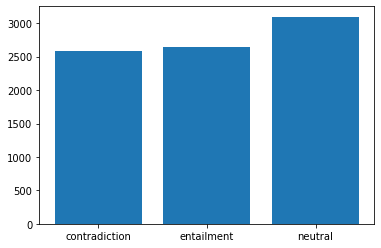

In [14]:
num_contradiction = len(df[df['label0'] == 'contradiction']) + len(df[df['label1'] == 'contradiction']) + len(df[df['label2'] == 'contradiction']) + len(df[df['label3'] == 'contradiction']) + len(df[df['label4'] == 'contradiction'])
num_entailment = len(df[df['label0'] == 'entailment']) + len(df[df['label1'] == 'entailment']) + len(df[df['label2'] == 'entailment']) + len(df[df['label3'] == 'entailment']) + len(df[df['label4'] == 'entailment'])
num_neutral = len(df[df['label0'] == 'neutral']) + len(df[df['label1'] == 'neutral']) + len(df[df['label2'] == 'neutral']) + len(df[df['label3'] == 'neutral']) + len(df[df['label4'] == 'neutral'])

labels = ['contradiction', 'entailment', 'neutral']
counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

In [15]:
def label_count(df):
  num_neutral = 0
  num_contradiction = 0
  num_entailment = 0
  cols = ['label0', 'label1', 'label2', 'label3', 'label4']

  for col in cols:
    if df[col] == 'neutral':
      num_neutral = num_neutral + 1
    if df[col] == 'contradiction':
      num_contradiction = num_contradiction + 1
    if df[col] == 'entailment':
      num_entailment = num_entailment + 1

  return [num_neutral, num_contradiction, num_entailment]

temp = df.apply(label_count, axis=1)

df['temp'] = temp

df['neutral'] = 0
df['contradiction'] = 0
df['entailment'] = 0

def list_to_num(list:list):
  return list[0]
df['neutral'] = df['temp'].map(list_to_num)

def list_to_num(list:list):
  return list[1]
df['contradiction'] = df['temp'].map(list_to_num)

def list_to_num(list:list):
  return list[2]
df['entailment'] = df['temp'].map(list_to_num)

def voting(df):
  cols = ['neutral', 'contradiction', 'entailment']
  for col in cols:
    if df[col] > 2:
      return col
  return 'neutral'

df['label'] = df.apply(voting, axis=1)

- 동일한 label이 3개 이상이면 해당 label로 분류
- 그 외 neutral

In [16]:
df.head(3)

,index,premise,hypothesis,label,label0,label1,label2,label3,label4,temp,neutral,contradiction,entailment
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction,contradiction,contradiction,contradiction,contradiction,contradiction,"[0, 5, 0]",0,5,0
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,neutral,neutral,neutral,neutral,neutral,neutral,"[5, 0, 0]",5,0,0
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment,entailment,entailment,entailment,entailment,entailment,"[0, 0, 5]",0,0,5


- label이 neutral에 지나치게 치중되는 경향을 보임

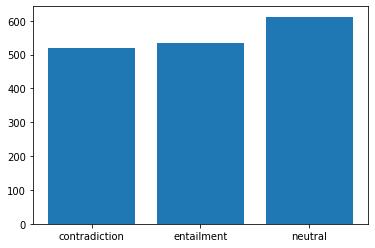

In [17]:
num_contradiction = df['label'].value_counts()['contradiction']
num_entailment = df['label'].value_counts()['entailment']
num_neutral = df['label'].value_counts()['neutral']

counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

- label이 neutral인 데이터 중 entailment와 contradiction로 분류될 가능성이 있는 데이터의 label 조정
  + neutral: 3 / contradiction: 2 -> **contradiction**
  + neutral: 3 / entailment: 2 -> **entailment**
  + neutral: 4 /  contradiction: 1 -> **contradiction**
  + neutral: 4 / entailment: 1 -> **entailment**

In [18]:
def make_label(list:list):
  if list == [3, 2, 0] :
    return 'contradiction'
  if list == [3, 0, 2]:
    return 'entailment'
  if list == [4, 1, 0]:
    return 'contradiction'
  if list == [4, 0, 1]:
    return 'entailment'
  else :
    return 'answer'

my_label = df['temp'].map(make_label)
df['my_label'] = my_label
my_answer = df[df['my_label'] != 'answer']
df.loc[my_answer.index, 'label'] = my_answer['my_label']

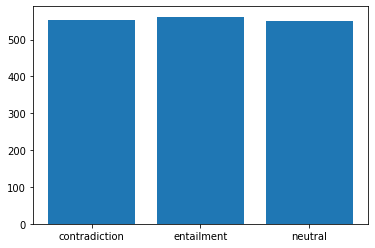

In [19]:
num_contradiction = df['label'].value_counts()['contradiction']
num_entailment = df['label'].value_counts()['entailment']
num_neutral = df['label'].value_counts()['neutral']

counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

In [20]:
submission = pd.read_csv('/content/drive/MyDrive/KLUE/sample_submission.csv')

In [21]:
submission['label'] = df['label']

In [22]:
submission

,index,label
0,0,contradiction
1,1,neutral
2,2,entailment
3,3,contradiction
4,4,contradiction
...,...,...
1661,1661,neutral
1662,1662,entailment
1663,1663,neutral
1664,1664,neutral


In [23]:
submission.to_csv('/content/drive/MyDrive/sm_220228/submission_hard.csv', index=False)

## softvoting

###  voting algorithm
  + <strong> 동일한 premise에 세 가지의 hypothesis가 매칭되는 경우, 가장 높은 확률을 갖는 hypothesis부터 label 부여  
  + 동일한 premise에 세 가지의 hypothesis가 매칭되지 않는 경우, 가장 큰 확률을 갖는 label 부여 </strong>

In [24]:
pred0 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob0.csv')
pred1 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob1.csv')
pred2 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob2.csv')
pred3 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob3.csv')
pred4 = pd.read_csv('/content/drive/MyDrive/sm_220228/pred_prob4.csv')

In [25]:
pred = pd.DataFrame((np.array(pred0) + np.array(pred1) + np.array(pred2) + np.array(pred3) + np.array(pred4))/5)
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')
test = pd.concat([test, pred], axis=1)
test.head(3)

,index,premise,hypothesis,label,0,1,2
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer,0.000112,0.999817,0.000071
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer,0.003301,0.000062,0.996636
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer,0.999655,0.000170,0.000176


* 모델의 예측 결과가 neutral에 치중되는 경향을 보임
  - label 별로 threshold를 다르게 해야 할 필요가 있음

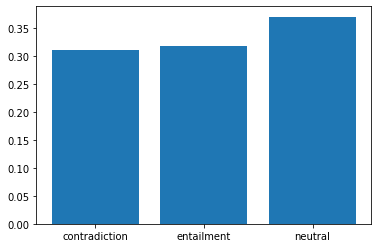

In [26]:
prob_entailment = test[0].mean()
prob_contradiction = test[1].mean()
prob_neutral = test[2].mean()

probs = [prob_contradiction, prob_entailment, prob_neutral]

plt.bar(labels, probs)
plt.show()

In [27]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(np.argmax(np.array(pred), axis=-1))

test['label'] = pd.DataFrame(answer)[1]
test.head(3)

,index,premise,hypothesis,label,0,1,2
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction,0.000112,0.999817,0.000071
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,neutral,0.003301,0.000062,0.996636
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment,0.999655,0.000170,0.000176


- 가장 큰 확률을 갖는 label을 부여하면 hardvoting과 같이 neutral에 치중되는 경향을 보임

- 분류된 데이터 중 5개의 label이 neutral과 entailment, neutral과 contradiction이 경합하면 entailment와 contradiction으로 재분류

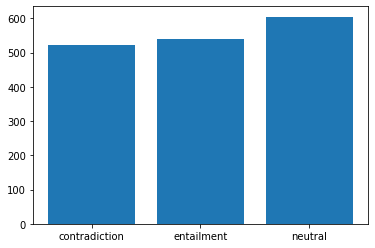

In [28]:
num_contradiction = test['label'].value_counts()['contradiction']
num_entailment = test['label'].value_counts()['entailment']
num_neutral = test['label'].value_counts()['neutral']

counts = [num_contradiction, num_entailment, num_neutral]

plt.bar(labels, counts)
plt.show()

- 보편적으로 하나의 premise에 세 가지의 hypothesis가 매칭

In [29]:
test.sort_values(by='premise')[:15]

,index,premise,hypothesis,label,0,1,2
1070,1070,10명이 함께 사용하기 불편함없이 만족했다.,10명이 함께 사용하기에 불편하지 않았다.,entailment,0.999548,0.000320,0.000133
1034,1034,10명이 함께 사용하기 불편함없이 만족했다.,남녀노소 10명이 함께 여행을 갔다.,neutral,0.000141,0.000073,0.999786
1644,1644,10명이 함께 사용하기 불편함없이 만족했다.,함께 사용하기에 10명은 너무 많은 숫자이다.,contradiction,0.000045,0.799890,0.200065
637,637,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,건물사람들을 위한 수영장과 썬베드가 있습니다.,entailment,0.999418,0.000352,0.000231
1122,1122,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,수영장과 썬베드는 훌륭한 편의시설 입니다.,neutral,0.000122,0.000096,0.999781
1215,1215,10층에 건물사람들만 이용하는 수영장과 썬베드들이 있구요.,건물사람이 아니라도 수영장과 썬베드를 이용할 수 있습니다.,contradiction,0.000150,0.912092,0.087758
337,337,"11월 5일, 정부가 국무회의에서 통합진보당에 대한 해산심판 청구안을 통과시켰으며,...",정부는 통합진보당에 대한 해산심판 청구안을 기각했다.,contradiction,0.000087,0.999831,0.000082
605,605,"11월 5일, 정부가 국무회의에서 통합진보당에 대한 해산심판 청구안을 통과시켰으며,...",법무부가 청구서를 제출한 날에 통합진보당은 해산됐다.,neutral,0.000183,0.000158,0.999659
1266,1266,"11월 5일, 정부가 국무회의에서 통합진보당에 대한 해산심판 청구안을 통과시켰으며,...",정부는가 청구안을 통과시킴에 따라 법무부는 즉시 통합진보당의 해산 청구서를 제출했다.,entailment,0.999499,0.000377,0.000124
1615,1615,14일 발표한 한국판 뉴딜은 디지털과 그린 뉴딜을 양대축으로 10대 과제를 선정해 ...,"한국판 뉴딜은 추진하되, 고용사회망 강화는 고려되지 않는다.",contradiction,0.000106,0.999828,0.000067


In [30]:
for i, sent in enumerate(test['premise'].unique()):
  if len(test[test['premise'] == sent]) == 3:
    continue
  else :
    print(sent)

한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 기탁했다.


In [31]:
test[test['premise'] == '한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 기탁했다.']

,index,premise,hypothesis,label,0,1,2
25,25,한겨례평화통일포럼은 18일 안산시 드림스타트 아동들에게 전달해 달라며 쌀 48포를 ...,한겨례평화통일포럼은 20키로 쌀로 기탁했다.,contradiction,0.010205,0.977261,0.012534


- 동일한 premise에 세 가지의 hypothesis가 매칭되는 경우, 가장 높은 확률을 갖는 hypothesis부터 label 부여
- 남은 hypothesis는 앞서 선정된 label을 제외한 두가지의 label 중 높은 확률을 갖는 label 부여
- 동일한 premise에 세 가지의 hypothesis가 매칭되지 않는 경우, 가장 큰 확률을 갖는 label 부여

In [32]:
def find_max(test):
  return max(test[0], test[1], test[2])

test['max'] = test.apply(find_max, axis=1)
test.sort_values(by='premise').head(3)

,index,premise,hypothesis,label,0,1,2,max
1070,1070,10명이 함께 사용하기 불편함없이 만족했다.,10명이 함께 사용하기에 불편하지 않았다.,entailment,0.999548,0.000320,0.000133,0.999548
1034,1034,10명이 함께 사용하기 불편함없이 만족했다.,남녀노소 10명이 함께 여행을 갔다.,neutral,0.000141,0.000073,0.999786,0.999786
1644,1644,10명이 함께 사용하기 불편함없이 만족했다.,함께 사용하기에 10명은 너무 많은 숫자이다.,contradiction,0.000045,0.799890,0.200065,0.799890


In [33]:
for i, sent in enumerate(test['premise'].unique()):
  labels = [0,1,2]
  if len(test[test['premise'] == sent]) == 3:
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0]['index']), 'label'] = test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels])]
    labels.remove(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels])])
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1]['index']), 'label'] = test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels])]
    labels.remove(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels].index[np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[1][labels])])
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[2]['index']), 'label'] = labels[0]
  else :
    test.loc[(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0]['index']), 'label'] = np.argmax(test[test['premise'] == sent].sort_values(by='max', ascending=False).iloc[0][labels])

In [34]:
test['label'] = pd.DataFrame(num_to_label(test['label']))[1]
test.head(3)

,index,premise,hypothesis,label,0,1,2,max
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,contradiction,0.000112,0.999817,0.000071,0.999817
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,entailment,0.003301,0.000062,0.996636,0.996636
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,entailment,0.999655,0.000170,0.000176,0.999655


In [35]:
submission = pd.read_csv('/content/drive/MyDrive/KLUE/sample_submission.csv')

In [36]:
submission['label'] = test['label']

In [37]:
submission

,index,label
0,0,contradiction
1,1,entailment
2,2,entailment
3,3,contradiction
4,4,contradiction
...,...,...
1661,1661,neutral
1662,1662,entailment
1663,1663,neutral
1664,1664,neutral


In [38]:
submission.to_csv('/content/drive/MyDrive/sm_220228/submission_soft.csv', index=False)